# Step - 2

## Preconditions

### Install the required libraries
```bash
pip install -r requirements.txt
```



In [1]:
# Importing the required libraries
import trimesh
import os
import matplotlib.pyplot as plt
import json
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd

## Step 2.1: Analyzing a Single Shape

In [2]:
def analyze_shape(_file_path):
    try:
        mesh = trimesh.load(_file_path)
        num_vertices = len(mesh.vertices)
        num_faces = len(mesh.faces)
        face_types = mesh.faces.shape[1]  # 3 for triangles, 4 for quads
        bounding_box = mesh.bounding_box.extents
        return num_vertices, num_faces, face_types, bounding_box
    except Exception as e:
        print(f"Error processing {_file_path}: {e}")
        return None

## Step 2.2: Statistics Over the Whole Database

In [6]:
# Getting the properties of all the shapes
shape_data = []

# Define the root folder where the search begins
root_folder = './ShapeDatabase_INFOMR-master'

# List to store all .obj file paths
obj_file_paths = []

# Walk through the folder structure
for dirpath, dirnames, filenames in os.walk(root_folder):
    for file in filenames:
        if file.endswith('.obj'):
            # Get the full file path and add it to the list
            full_path = os.path.join(dirpath, file)
            obj_file_paths.append(full_path)

# Print all .obj file paths                                                                                  
for path in obj_file_paths:
    file_path = path.replace('\\', '/')
    genre = file_path.split('/')[-2]
    shape_name = file_path.split('/')[-1].split('.')[0]
    shape_properties = analyze_shape(file_path)
    shape_data.append({
        'file_path': file_path,
        'genre': genre,
        'shape_name': shape_name,
        'num_vertices': shape_properties[0],
        'num_faces': shape_properties[1],
        'face_types': shape_properties[2],
        'bounding_box': shape_properties[3].tolist()
    })

In [7]:
# Save the shape data to a file
# import json
# with open('raw_shape_data.json', 'w') as f:
#     json.dump(shape_data, f)

In [3]:
# Load the shape data from the file
import json
with open('raw_shape_data.json', 'r') as f:
    shape_data = json.load(f)

In [4]:
shape_data[0]

{'file_path': './ShapeDatabase_INFOMR-master/AircraftBuoyant/m1337.obj',
 'genre': 'AircraftBuoyant',
 'shape_name': 'm1337',
 'num_vertices': 201,
 'num_faces': 340,
 'face_types': 3,
 'bounding_box': [0.864234, 0.95, 0.864234]}

In [5]:
len(shape_data)

2483

## Step 2.3: Resampling Outliers

In [6]:
# remove the outliers from the shape_data where num_vertices <= 100 or num_faces <= 100
# shape_data_filtered = [data for data in shape_data if data['num_vertices'] > 100 and data['num_faces'] > 100]
#print(f"Number of outliers: {len(shape_data) - len(shape_data_filtered)}")
MIN_NUM_VERTICES = 10000
outliers = [data for data in shape_data if data['num_vertices'] <= MIN_NUM_VERTICES]
print(f"Number of outliers: {len(outliers)}")


Number of outliers: 2121


In [7]:
def refine_mesh(target_mesh, target_vertex_count=MIN_NUM_VERTICES):
    # 获取当前顶点数量
    current_vertex_count = len(target_mesh.vertices)
    
    # 如果顶点数大于等于目标数量，不进行任何处理
    if current_vertex_count >= target_vertex_count:
        return target_mesh

    # 当顶点数小于目标数量时，细分直到接近目标数量
    while len(target_mesh.vertices) < target_vertex_count:
        # 使用 trimesh 的 subdivide 方法来细分
        target_mesh = target_mesh.subdivide()
        
        # 每次细分后检查顶点数量
        if len(target_mesh.vertices) >= target_vertex_count:
            break
    
    return target_mesh


In [8]:
refinement_folder = './refined_shapes'

In [80]:
#refinement_folder = './refined_shapes'
refined_shapes = []
for row in outliers:
    try:
        mesh = trimesh.load(row['file_path'])
        refined_mesh = refine_mesh(mesh)
        # 
        row['num_vertices'] = len(refined_mesh.vertices)
        row['num_faces'] = len(refined_mesh.faces)
        row['face_types'] = refined_mesh.faces.shape[1]
        row['bounding_box'] = refined_mesh.bounding_box.extents.tolist()
        refined_shapes.append(row)
        # save the refined mesh to the refined_shapes folder
        refined_mesh.export(f"{refinement_folder}/{row['genre']}~{row['shape_name']}~refined.obj")
    except Exception as e:
        print(f"Error refining {row['file_path']}: {e}")

In [81]:
# describe the vertices and faces in refined_shapes
vertices = [data['num_vertices'] for data in refined_shapes]
faces = [data['num_faces'] for data in refined_shapes]
print(f"Vertices: Min: {min(vertices)}, Max: {max(vertices)}, Mean: {np.mean(vertices)}, Median: {np.median(vertices)}")
print(f"Faces: Min: {min(faces)}, Max: {max(faces)}, Mean: {np.mean(faces)}, Median: {np.median(faces)}")

Vertices: Min: 10002, Max: 39890, Mean: 22115.91937765205, Median: 21072.0
Faces: Min: 13808, Max: 430080, Mean: 55545.99905704856, Median: 45056.0


In [82]:
# read the refined data from the refined_shapes folder
resampled_shape_data = []
for dirpath, dirnames, filenames in os.walk(refinement_folder):
    for file in filenames:
        if file.endswith('.obj'):
            # Get the full file path and add it to the list
            full_path = dirpath + '/' + file
            genre = file.split('~')[0]
            shape_name = file.split('~')[1].split('.')[0]
            shape_properties = analyze_shape(full_path)
            resampled_shape_data.append({
                'file_path': full_path,
                'genre': genre,
                'shape_name': shape_name,
                'num_vertices': shape_properties[0],
                'num_faces': shape_properties[1],
                'face_types': shape_properties[2],
                'bounding_box': shape_properties[3].tolist()
            })

In [83]:
# describe the vertices and faces in resampled_data 
vertices = [data['num_vertices'] for data in resampled_shape_data]
faces = [data['num_faces'] for data in resampled_shape_data]
print(f"Vertices: Min: {min(vertices)}, Max: {max(vertices)}, Mean: {np.mean(vertices)}, Median: {np.median(vertices)}")
print(f"Faces: Min: {min(faces)}, Max: {max(faces)}, Mean: {np.mean(faces)}, Median: {np.median(faces)}")

len([_ for _ in resampled_shape_data if _['num_vertices'] <= MIN_NUM_VERTICES])

# print the file path of the shapes that have fewer vertices than the threshold
for data in resampled_shape_data:
    if data['num_vertices'] <= MIN_NUM_VERTICES:
        print(data['file_path'])

Vertices: Min: 8751, Max: 39890, Mean: 22078.08109382367, Median: 21072.0
Faces: Min: 13808, Max: 430080, Mean: 55545.99905704856, Median: 45056.0
./refined_shapes/Musical_Instrument~m633~refined.obj


In [87]:
# replace the outliers data with the refined shapes data in shape_data
shape_data_after_resampled = [data for data in shape_data if data not in outliers]
shape_data_after_resampled.extend(resampled_shape_data)

In [89]:
len(shape_data_after_resampled)
#len([e for e in shape_data_after_resampled if e['num_vertices'] <= MIN_NUM_VERTICES])

2483

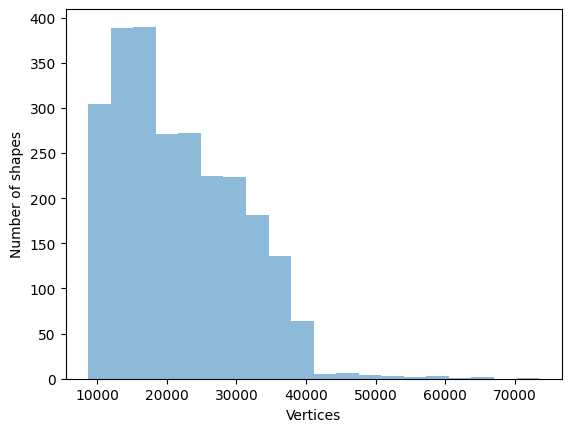

In [90]:
# Data preparation
vertices = [data['num_vertices'] for data in shape_data_after_resampled]
faces = [data['num_faces'] for data in shape_data_after_resampled]

# show the histogram of the vertices
plt.hist(vertices, bins=20, alpha=0.5, label='Vertices')
# X axis label as Vertices
plt.xlabel('Vertices')
# Y axis label as Number of shapes
plt.ylabel('Number of shapes')
plt.show()



# # Histogram plot
# plt.hist(vertices, bins=20, alpha=0.5, label='Vertices')
# plt.hist(faces, bins=20, alpha=0.5, label='Faces')
# plt.legend(loc='upper right')                                                                                                                                                                                                                                                                                                            
# plt.show()

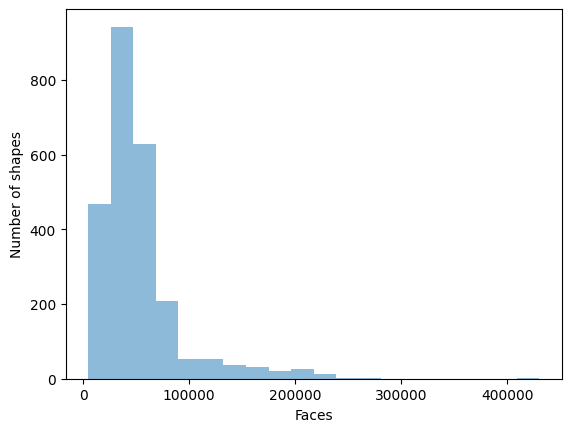

In [91]:
# show the histogram of the faces
plt.hist(faces, bins=20, alpha=0.5, label='Faces')
# X axis label as Faces
plt.xlabel('Faces')
# Y axis label as Number of shapes
plt.ylabel('Number of shapes')
plt.show()

In [92]:
# describe the vertices and faces
vertices = [data['num_vertices'] for data in shape_data_after_resampled]
faces = [data['num_faces'] for data in shape_data_after_resampled]
print(f"Vertices: Min: {min(vertices)}, Max: {max(vertices)}, Mean: {np.mean(vertices)}, Median: {np.median(vertices)}")
print(f"Faces: Min: {min(faces)}, Max: {max(faces)}, Mean: {np.mean(faces)}, Median: {np.median(faces)}")

Vertices: Min: 8751, Max: 73440, Mean: 21884.297623842125, Median: 20280.0
Faces: Min: 4891, Max: 430080, Mean: 53070.053966975436, Median: 43008.0


In [19]:
# save resampled data to a file
# import json
# with open('shape_data_after_resampled.json', 'w') as f:
#     json.dump(shape_data_after_resampled, f)

In [7]:
# load the resampled data from the file
# import json
# with open('shape_data_after_resampled.json', 'r') as f:
#     shape_data_after_resampled = json.load(f)

## Step 2.3.1: balance the classes

69


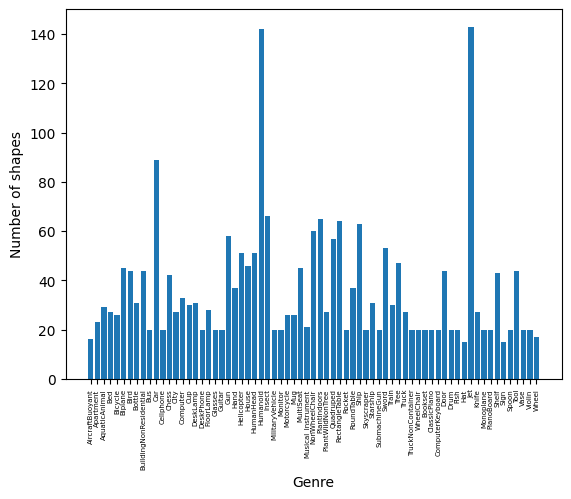

In [93]:
# check the number of each genre in the dataset
# then plot the bar chart
# then x-axis is the genre and y-axis is the number of shapes in that genre
from collections import Counter
genre_count = Counter([data['genre'] for data in shape_data_after_resampled])
print(len(genre_count))
plt.bar(genre_count.keys(), genre_count.values())
# and the x-axis should be tilted 45 degrees
plt.xticks(rotation=90)
# and the x-axies fonr size should be 5
plt.xticks(fontsize=5)
# X AXIS LABEL AS geNRE
plt.xlabel('Genre')
# Y AXIS LABEL AS Number of shapes
plt.ylabel('Number of shapes')
# make the figure size bigger
plt.show()

In [94]:
# find the median and avrage number of the genre_count
import numpy as np
median = np.median(list(genre_count.values()))
average = np.mean(list(genre_count.values()))
print(f"Median: {median}, Average: {average}")


Median: 27.0, Average: 35.98550724637681


In [95]:
# Choose the average number of shapes per genre as the threshold
# for those genres that have fewer shapes than the threshold, we will upsample them
# for those genres that have more shapes than the threshold, we will downsample them
import random
threshold = int(average)
print(f"Threshold: {threshold}")
# UP_SAMPLING_LIMITATION = threshold - 5
# DOWN_SAMPLING_LIMITATION = threshold + 5

# Resampling the data
balanced_shape_data = []
for genre, count in genre_count.items():
    genre_data = [data for data in shape_data_after_resampled if data['genre'] == genre]
    print(f"Genre: {genre}, Count: {count}")
    if count >= threshold:
        # 当计数大于下采样限制时，进行下采样
        # 随机选择一部分数据
        random.shuffle(genre_data)
        balanced_shape_data.extend(genre_data[:threshold])
    else:
        # 如果在限制范围内，直接使用现有数据
        balanced_shape_data.extend(genre_data)
    # if count >= threshold:
    #     # 当计数大于下采样限制时，进行下采样
    #     # 随机选择一部分数据
    #     random.shuffle(genre_data)
    #     resampled_data.extend(genre_data[:threshold])
    # if count < threshold:
    #     random.shuffle(genre_data)
    #     # 当计数小于上采样限制时，进行上采样
    #     resampled_data.extend(genre_data * (threshold // count))
    #     resampled_data.extend(genre_data[:threshold % count])
    # else: 
    #     # 当计数大于下采样限制时，进行下采样
    #     # 随机选择一部分数据
    #     random.shuffle(genre_data)
    #     resampled_data.extend(genre_data[:threshold])
    # else:
    #     # 如果在限制范围内，直接使用现有数据
    #     resampled_data.extend(genre_data)


Threshold: 35
Genre: AircraftBuoyant, Count: 16
Genre: Apartment, Count: 23
Genre: AquaticAnimal, Count: 29
Genre: Bed, Count: 27
Genre: Bicycle, Count: 26
Genre: Biplane, Count: 45
Genre: Bird, Count: 44
Genre: Bottle, Count: 31
Genre: BuildingNonResidential, Count: 44
Genre: Bus, Count: 20
Genre: Car, Count: 89
Genre: Cellphone, Count: 20
Genre: Chess, Count: 42
Genre: City, Count: 27
Genre: Computer, Count: 33
Genre: Cup, Count: 30
Genre: DeskLamp, Count: 31
Genre: DeskPhone, Count: 20
Genre: FloorLamp, Count: 28
Genre: Glasses, Count: 20
Genre: Guitar, Count: 20
Genre: Gun, Count: 58
Genre: Hand, Count: 37
Genre: Helicopter, Count: 51
Genre: House, Count: 46
Genre: HumanHead, Count: 51
Genre: Humanoid, Count: 142
Genre: Insect, Count: 66
Genre: MilitaryVehicle, Count: 20
Genre: Monitor, Count: 20
Genre: Motorcycle, Count: 26
Genre: Mug, Count: 26
Genre: MultiSeat, Count: 45
Genre: Musical_Instrument, Count: 21
Genre: NonWheelChair, Count: 60
Genre: PlantIndoors, Count: 65
Genre: Pl

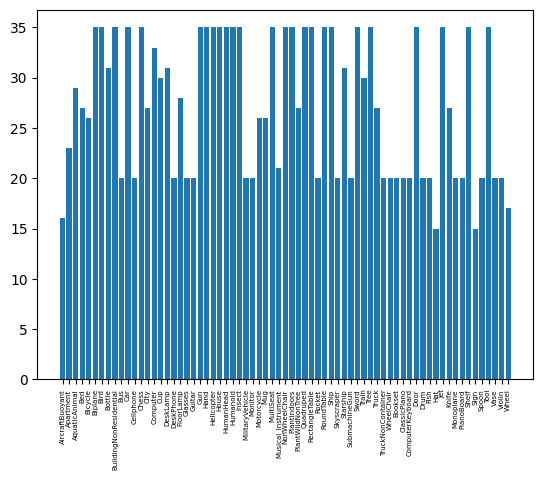

In [96]:
balanced_shape_data_genre_count = Counter([data['genre'] for data in balanced_shape_data])

plt.bar(balanced_shape_data_genre_count.keys(), balanced_shape_data_genre_count.values())
# and the x-axis should be tilted 45 degrees
plt.xticks(rotation=90)
# and the x-axies fonr size should be 5
plt.xticks(fontsize=5)
# make the figure size bigger
plt.show()

In [97]:
balanced_shape_data_genre_count

Counter({'AircraftBuoyant': 16,
         'Apartment': 23,
         'AquaticAnimal': 29,
         'Bed': 27,
         'Bicycle': 26,
         'Biplane': 35,
         'Bird': 35,
         'Bottle': 31,
         'BuildingNonResidential': 35,
         'Bus': 20,
         'Car': 35,
         'Cellphone': 20,
         'Chess': 35,
         'City': 27,
         'Computer': 33,
         'Cup': 30,
         'DeskLamp': 31,
         'DeskPhone': 20,
         'FloorLamp': 28,
         'Glasses': 20,
         'Guitar': 20,
         'Gun': 35,
         'Hand': 35,
         'Helicopter': 35,
         'House': 35,
         'HumanHead': 35,
         'Humanoid': 35,
         'Insect': 35,
         'MilitaryVehicle': 20,
         'Monitor': 20,
         'Motorcycle': 26,
         'Mug': 26,
         'MultiSeat': 35,
         'Musical_Instrument': 21,
         'NonWheelChair': 35,
         'PlantIndoors': 35,
         'PlantWildNonTree': 27,
         'Quadruped': 35,
         'RectangleTable': 35,
      

In [98]:
# Save the resampled shape data to a file
# import json
# with open('balanced_resampled_data.json', 'w') as f:
    # json.dump(balanced_shape_data, f)

In [16]:
# Load the shape data from the file
import json
with open('balanced_resampled_data.json', 'r') as f:
    balanced_shape_data = json.load(f)

In [99]:
# describe the vertices and faces in balanced resampled data
vertices = [data['num_vertices'] for data in balanced_shape_data]
faces = [data['num_faces'] for data in balanced_shape_data]
print(f"Vertices: Min: {min(vertices)}, Max: {max(vertices)}, Mean: {np.mean(vertices)}, Median: {np.median(vertices)}")
print(f"Faces: Min: {min(faces)}, Max: {max(faces)}, Mean: {np.mean(faces)}, Median: {np.median(faces)}")

Vertices: Min: 8751, Max: 73440, Mean: 21833.32907348243, Median: 20275.5
Faces: Min: 4891, Max: 430080, Mean: 55891.87380191693, Median: 44032.0


## Step 2.4: translated & scaled

In [100]:
def translated_scaled_shape(_path):
    _mesh = trimesh.load(_path)
    previous_num_vertices = len(_mesh.vertices)

    _centroid = _mesh.centroid
    _mesh.vertices -= _centroid  # 平移到原点
    _max_extent = _mesh.bounding_box.extents.max()  # 获取最大边长
    if _max_extent > 0:
        _mesh.vertices /= _max_extent  # 统一缩放
    after_num_vertices = len(_mesh.vertices)
    if previous_num_vertices != after_num_vertices:
        print(f"Before: {previous_num_vertices}, After: {after_num_vertices} ", _path)
    return _mesh

In [102]:
# read the refined data's path from the refined_shapes folder
refined_shape_data_paths = []
for dirpath, dirnames, filenames in os.walk('./refined_shapes'):
    for file in filenames:
        if file.endswith('.obj'):
            # Get the full file path and add it to the list
            full_path = './ShapeDatabase_INFOMR-master/' + file.split('~')[0] + '/' + file.split('~')[1] + '.obj'
            refined_shape_data_paths.append(full_path)
            


In [103]:
len(refined_shape_data_paths)

2121

In [104]:
# save all the translated & scaled shapes to a folder

# 1.create the genre folders
genre_names = list(balanced_shape_data_genre_count.keys())
for genre in genre_names:
    os.makedirs(f'./translated_scaled/{genre}', exist_ok=False)
    
# 2.save the translated and scaled shapes to the genre folders
for data in balanced_shape_data:
    if data['file_path'] in refined_shape_data_paths:
        mesh_path = './refined_shapes/' + data['genre'] + '_' + data['shape_name'] + '_refined.obj'
    else: 
        mesh_path = data['file_path']
    translated_scaled_mesh = translated_scaled_shape(mesh_path)
    translated_scaled_mesh.export(f"./translated_scaled/{data['genre']}/{data['shape_name']}.obj")

In [105]:
# 3.save the shape data to a file
# Getting the properties of all the shapes
translated_scaled_shape_data = []

# Define the root folder where the search begins
translated_scaled_shape_folder = './translated_scaled'

# List to store all .obj file paths
translated_scaled_obj_file_paths = []

# Walk through the folder structure
for dirpath, dirnames, filenames in os.walk(translated_scaled_shape_folder):
    for file in filenames:
        if file.endswith('.obj'):
            # Get the full file path and add it to the list
            full_path = os.path.join(dirpath, file)
            translated_scaled_obj_file_paths.append(full_path)

In [106]:
len(translated_scaled_obj_file_paths)

1878

In [107]:
# Print all .obj file paths                                                                                  
for path in translated_scaled_obj_file_paths:
    file_path = path.replace('\\', '/')
    genre = file_path.split('/')[-2]
    shape_name = file_path.split('/')[-1].split('.')[0]
    shape_properties = analyze_shape(file_path)
    translated_scaled_shape_data.append({
        'file_path': file_path,
        'genre': genre,
        'shape_name': shape_name,
        'num_vertices': shape_properties[0],
        'num_faces': shape_properties[1],
        'face_types': shape_properties[2],
        'bounding_box': shape_properties[3].tolist(),
        'centroid': trimesh.load(file_path).centroid.tolist(),
    })

In [108]:
len(translated_scaled_shape_data)

1878

In [109]:
# describe the vertices and faces in normalized shape data
vertices = [data['num_vertices'] for data in translated_scaled_shape_data]
faces = [data['num_faces'] for data in translated_scaled_shape_data]
print(f"Vertices: Min: {min(vertices)}, Max: {max(vertices)}, Mean: {np.mean(vertices)}, Median: {np.median(vertices)}")
print(f"Faces: Min: {min(faces)}, Max: {max(faces)}, Mean: {np.mean(faces)}, Median: {np.median(faces)}")

Vertices: Min: 8751, Max: 73440, Mean: 21829.51863684771, Median: 20275.5
Faces: Min: 4891, Max: 430080, Mean: 55891.87380191693, Median: 44032.0


In [110]:
with open('translation_shape_data.json', 'w') as f:
    json.dump(translated_scaled_shape_data, f)

In [35]:
# check if the normalization works
# condition 1: the centroid of the shape should be (0, 0, 0)
# condition 2: the max extent of the shape should be 1
# import numpy as np
# 
# # 定义容差值
# EPSILON = 0.5  # 根据需要调整
# 
# # 假设 normalized_shape_data 是包含归一化后网格数据的列表
# for data in normalized_shape_data:
#     centroid = data['centroid']
#     file_path = data['file_path']
#     
#     # 条件 1: 检查重心是否接近 (0, 0, 0)
#     if not np.allclose(centroid, [0, 0, 0], atol=EPSILON):
#         print(f"Error: {file_path} 的重心 {centroid} 不接近 (0, 0, 0)")
#     
#     # 加载归一化后的网格
#     mesh = trimesh.load(file_path)
#     
#     # 条件 2: 检查最大边长是否接近 1
#     max_extent = mesh.bounding_box.extents.max()
#     if not np.isclose(max_extent, 1.0, atol=EPSILON):
#         print(f"Error: {file_path} 的最大边长 {max_extent} 不接近 1")

# Step 3.1: Full Normalization

In [122]:
# Load the normalized shape data from the JSON file
# import json
# with open('translated_scaled_shape_data.json', 'r') as f:
#     translated_scaled_shape_data = json.load(f)

# Step 3.1: Full Normalization

def normalize_shape(translated_scaled_mesh):
    # Step 1: Compute PCA to get eigenvectors
    pca = PCA(n_components=3)
    pca.fit(translated_scaled_mesh.vertices)

    # 获取前两个特征向量（主成分）
    eigenvectors = pca.components_

    # Step 2: Create a rotation matrix to align the first two eigenvectors with x and y axes
    # 计算旋转矩阵
    rotation_matrix = np.array([
        eigenvectors[0],   # 第一主成分对齐到 x 轴
        eigenvectors[1],   # 第二主成分对齐到 y 轴
        np.cross(eigenvectors[0], eigenvectors[1])  # 第三主成分对齐到 z 轴
    ])

    # Step 3: Apply the rotation to the vertices
    translated_scaled_mesh.vertices = translated_scaled_mesh.vertices @ rotation_matrix.T  # 应用旋转矩阵

    # Step 4: Flipping - Use moment test to determine if flipping is necessary
    for axis in range(3):
        if np.sum(translated_scaled_mesh.vertices[:, axis] ** 3) < 0:
            translated_scaled_mesh.vertices[:, axis] *= -1

    return translated_scaled_mesh

In [123]:
for data in translated_scaled_shape_data:  # Only select a few shapes for experimentation
    try:
        shape = trimesh.load(data['file_path'])
        normalized_mesh = normalize_shape(shape)
        # save the normalized mesh to the normalized_shapes folder
        normalized_mesh.export(f"E:/UU/00-MR-Organization/normalized_shapes/{data['genre']}~{data['shape_name']}~normalized.obj")
    except Exception as e:
        print(f"Error processing {data['file_path']}: {e}")

In [124]:
normalized_shape_data = []
for dirpath, dirnames, filenames in os.walk('E:/UU/00-MR-Organization/normalized_shapes'):
    for file in filenames:
        if file.endswith('.obj'):
            # Get the full file path and add it to the list
            full_path = dirpath + '/' + file
            genre = file.split('~')[0]
            shape_name = file.split('~')[1]
            shape_properties = analyze_shape(full_path)
            normalized_shape_data.append({
                'file_path': full_path,
                'genre': genre,
                'shape_name': shape_name,
                'num_vertices': shape_properties[0],
                'num_faces': shape_properties[1],
                'face_types': shape_properties[2],
                'bounding_box': shape_properties[3].tolist()
            })

In [125]:
len(normalized_shape_data)

1878

In [126]:
# describe the vertices and faces in normalized shape data
vertices = [data['num_vertices'] for data in normalized_shape_data]
faces = [data['num_faces'] for data in normalized_shape_data]
print(f"Vertices: Min: {min(vertices)}, Max: {max(vertices)}, Mean: {np.mean(vertices)}, Median: {np.median(vertices)}")
print(f"Faces: Min: {min(faces)}, Max: {max(faces)}, Mean: {np.mean(faces)}, Median: {np.median(faces)}")


Vertices: Min: 8751, Max: 73440, Mean: 21829.504792332267, Median: 20275.5
Faces: Min: 4891, Max: 430080, Mean: 55891.87380191693, Median: 44032.0


In [127]:
# Save the normalized shape data to a file
# import json
# with open('normalized_shape_data.json', 'w') as f:
#     json.dump(normalized_shape_data, f)

In [ ]:
# Load the normalized shape data from the JSON file
import json
with open('normalized_shape_data.json', 'r') as f:
    normalized_shape_data = json.load(f)

# Step 3.2: Feature Extraction


In [4]:
def extract_features(mesh):
    features = {}

    # Elementary Descriptors
    features['Surface Area'] = mesh.area
    features['Compactness'] = (36 * np.pi * (mesh.volume ** 2)) / (mesh.area ** 3)  # Compactness with respect to a sphere
    obb = mesh.bounding_box_oriented
    features['3D Rectangularity'] = mesh.volume / obb.volume
    features['Diameter'] = np.max(mesh.bounding_box.extents)
    convex_hull = mesh.convex_hull
    features['Convexity'] = mesh.volume / convex_hull.volume
    covariance_matrix = np.cov(mesh.vertices, rowvar=False)
    eigenvalues, _ = np.linalg.eigh(covariance_matrix)
    features['Eccentricity'] = max(eigenvalues) / min(eigenvalues)

    # Property Descriptors (using histograms)
    num_samples = 1000
    bins = 10  # Number of bins for the histogram

    random_points = mesh.vertices[np.random.choice(mesh.vertices.shape[0], num_samples, replace=True)]

    # A3: Angle between 3 random vertices
    angles = []
    for i in range(num_samples):
        v1, v2, v3 = random_points[np.random.choice(num_samples, 3, replace=False)]
        vec1 = v2 - v1
        vec2 = v3 - v1
        cos_theta = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
        if -1.0 <= cos_theta <= 1.0:  # Ensure valid range for arccos
            angles.append(np.arccos(cos_theta))
    features['A3'] = np.histogram(angles, bins=bins, range=(0, np.pi))[0]

    # D1: Distance between barycenter and random vertex
    barycenter = mesh.center_mass
    distances = np.linalg.norm(random_points - barycenter, axis=1)
    features['D1'] = np.histogram(distances, bins=bins)[0]

    # D2: Distance between 2 random vertices
    d2_distances = []
    for i in range(num_samples // 2):
        v1, v2 = random_points[np.random.choice(num_samples, 2, replace=False)]
        d2_distances.append(np.linalg.norm(v1 - v2))
    features['D2'] = np.histogram(d2_distances, bins=bins)[0]

    # D3: Square root of area of triangle given by 3 random vertices
    areas = []
    for i in range(num_samples // 3):
        v1, v2, v3 = random_points[np.random.choice(num_samples, 3, replace=False)]
        if not np.allclose(np.cross(v2 - v1, v3 - v1), 0):  # Ensure points are not collinear
            area = np.linalg.norm(np.cross(v2 - v1, v3 - v1)) / 2
            areas.append(np.sqrt(area))
    features['D3'] = np.histogram(areas, bins=bins)[0]

    # D4: Cube root of volume of tetrahedron formed by 4 random vertices
    volumes = []
    for i in range(num_samples // 4):
        retries = 0
        while retries < 5:  # Try up to 5 times to find non-coplanar points
            v1, v2, v3, v4 = random_points[np.random.choice(num_samples, 4, replace=False)]
            volume = np.abs(np.dot(v4 - v1, np.cross(v2 - v1, v3 - v1))) / 6
            if volume > 0:  # Ensure points are not coplanar
                volumes.append(np.cbrt(volume))
                break
            retries += 1
    features['D4'] = np.histogram(volumes, bins=bins)[0]

    return features

In [6]:
# compare to the original shape data to see which shapes are missing
[shape['file_path'] for shape in normalized_shape_data if shape['file_path'] not in features_df['Shape File'].values]

['./normalized_database/Door/D01121.obj',
 './normalized_database/Door/m1708.obj',
 './normalized_database/Tree/m1097.obj',
 './normalized_database/Vase/m541.obj']

In [9]:
# Save the features to a csv file
# features_df.to_csv('shape_features.csv', index=False)

# make the np.arry to list in all_features
for feature in all_features:
    for key in ['A3', 'D1', 'D2', 'D3', 'D4']:
        feature[key] = feature[key].tolist()
        
    

# Save the features to a json file
import json
with open('shape_features.json', 'w') as f:
    json.dump(all_features, f)


# Step 4 - Normalization Features and Create the Combined feature

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
import ast
import matplotlib.pyplot as plt

In [11]:
# 标量特征列
scalar_features = ['Surface Area', 'Compactness', '3D Rectangularity', 'Diameter', 'Convexity', 'Eccentricity']

# 向量特征列
vector_features = ['A3', 'D1', 'D2', 'D3', 'D4']

In [12]:
# 展平向量特征，并填充缺失的维度（假设所有向量长度相同）
def flatten_vectors(row, vector_length=10):
    flattened = []
    for col in vector_features:
        vec = row[col]
        if len(vec) < vector_length:
            vec = np.pad(vec, (0, vector_length - len(vec)), 'constant')
        else:
            vec = vec[:vector_length]
        flattened.extend(vec)
    return flattened

In [13]:
# 加载特征数据
# features_df = pd.read_csv('shape_features.csv')
features_df = pd.read_json('shape_features.json')

In [14]:
# 创建新的特征列
features_df['combined_features'] = features_df.apply(flatten_vectors, axis=1)

# 分离标量和向量特征
X_scalar = features_df[scalar_features].values
X_vector = np.stack(features_df['combined_features'].values)

# 标准化标量特征
scaler_standard = StandardScaler()
X_scalar_standard = scaler_standard.fit_transform(X_scalar)

# 最小-最大归一化标量特征
scaler_minmax = MinMaxScaler()
X_scalar_minmax = scaler_minmax.fit_transform(X_scalar)

# 合并所有特征（这里以标准化为例）
X_combined = np.hstack([X_scalar_standard, X_vector])

In [15]:
# 创建包含归一化特征的新 DataFrame
df_normalized = pd.DataFrame(X_combined, columns=[f'scalar_{i}' for i in range(X_scalar_standard.shape[1])] + 
                                                [f'vector_{i}' for i in range(X_vector.shape[1])])

# 添加 Shape File 列（或其他标识列）
df_normalized['Shape File'] = features_df['Shape File']


# 显示前几行
print(df_normalized.head())

   scalar_0   scalar_1  scalar_2  scalar_3  scalar_4  scalar_5  vector_0  \
0  -0.02697   1.957984  0.685726 -0.028376  0.928612 -0.168065      84.0   
1  -0.02697   0.852699  0.659020 -0.028376  0.881600 -0.168339      86.0   
2  -0.02697  -0.276542  0.002750 -0.028282  0.023719 -0.160142     200.0   
3  -0.02697  14.599981  1.058650 -0.028329  1.821746 -0.131345     251.0   
4  -0.02697   1.658418 -0.575961 -0.028357 -0.890028 -0.125738     327.0   

   vector_1  vector_2  vector_3  ...  vector_41  vector_42  vector_43  \
0     181.0     215.0     175.0  ...        8.0       18.0       33.0   
1     190.0     197.0     209.0  ...       17.0       25.0       40.0   
2     173.0     155.0     120.0  ...       45.0       64.0       39.0   
3     127.0     122.0     126.0  ...       61.0       47.0       45.0   
4     128.0      91.0      95.0  ...       26.0       43.0       51.0   

   vector_44  vector_45  vector_46  vector_47  vector_48  vector_49  \
0       40.0       52.0       46.

In [16]:
# 保存到新的 CSV 文件
df_normalized.to_csv('normalized_features.csv', index=False)

In [17]:
# 保存标准化器
import joblib
joblib.dump(scaler_standard, 'scaler_standard.pkl')

['scaler_standard.pkl']